In [52]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.special as sp
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn import decomposition
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt

In [53]:
# importing data
df = pd.read_csv('insurance.csv')

In [54]:
# first look on data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Point 1
#### Checking the distribution of variables

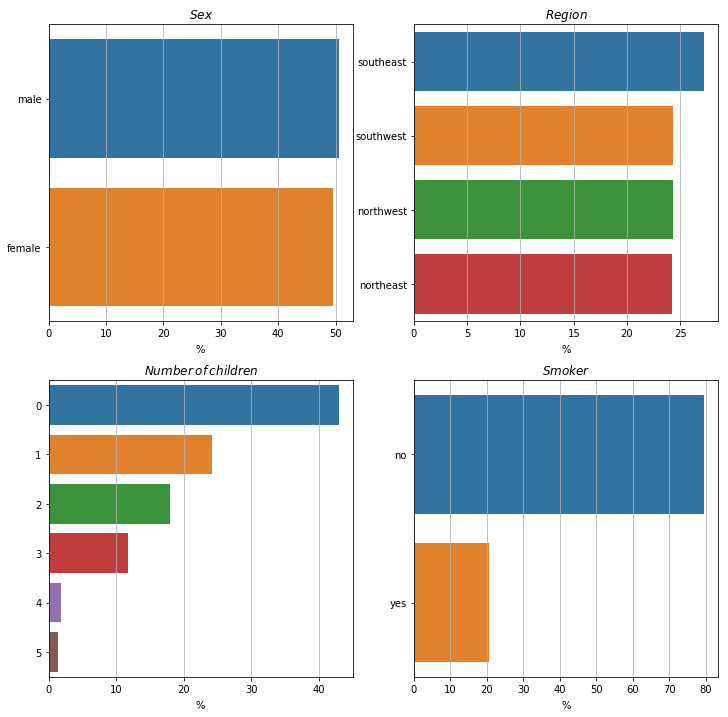

In [55]:
# Plotting barplots to see the rations between classes in binary and categorical variables
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.barplot(x=df['sex'].value_counts().values * 100 / df.shape[0],\
            y=df['sex'].value_counts().index, orient = 'h')
plt.xlabel('$\%$')
plt.title('$Sex$')
plt.grid(axis='x')

plt.subplot(2, 2, 2)
sns.barplot(x=df['region'].value_counts().values * 100 / df.shape[0],\
            y=df['region'].value_counts().index, orient = 'h')
plt.xlabel('$\%$')
plt.title('$Region$')
plt.grid(axis='x')

plt.subplot(2, 2, 3)
sns.barplot(x=df['children'].value_counts().values * 100 / df.shape[0],\
            y=df['children'].value_counts().index, orient= 'h')
plt.xlabel('$\%$')
plt.title('$Number\:of\:children$')
plt.grid(axis='x')

plt.subplot(2, 2, 4)
sns.barplot(x=df['smoker'].value_counts().values * 100 / df.shape[0],\
            y=df['smoker'].value_counts().index, orient = 'h')
plt.xlabel('$\%$')
plt.title('$Smoker$')
plt.grid(axis='x')

plt.show()

C:\Users\Alexey\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


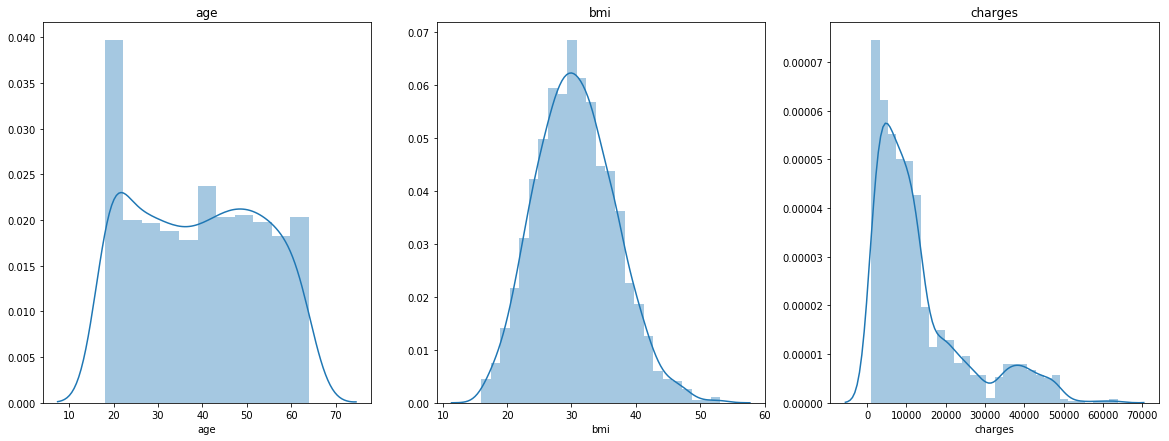

In [56]:
# Plotting the distributions of the continuous variables
plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
sns.distplot(df['age'])
plt.title('age')

plt.subplot(1, 3, 2)
sns.distplot(df['bmi'])
plt.title('bmi')

plt.subplot(1, 3, 3)
sns.distplot(df['charges'])
plt.title('charges')

plt.show()

### Point 2
#### Checking the proportions of some features in several groups

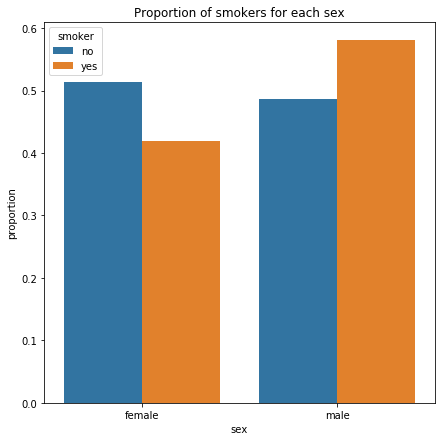

In [57]:
# Plotting the proportions of smokers/non-smokers for each sex
plt.figure(figsize=(7, 7))
x, y, hue = 'sex', 'proportion', 'smoker'

prop_df = df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index()
sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.title('Proportion of smokers for each sex')
plt.show()

### Point 3
#### Checking the distribution of males and females

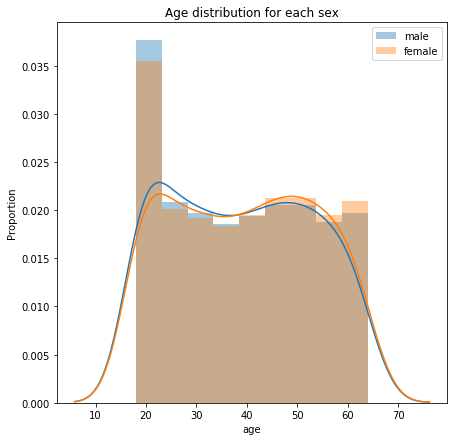

In [58]:
# Finding out is there difference between age distributions for each sex  
plt.figure(figsize=(7, 7))
sns.distplot(df[df['sex'] == 'male']['age'], color = 'tab:blue', label = 'male')
sns.distplot(df[df['sex'] == 'female']['age'], color = 'tab:orange', label = 'female')
plt.legend()
plt.title('Age distribution for each sex')
plt.ylabel('Proportion')
plt.show()

### Point 4
#### Checking is the mean charges of females equals the mean charges of males

$$H_0: \overline{\rm charges}_M = \overline{\rm charges}_F$$ 

$$vs$$

$$H_1: \overline{\rm charges}_M \neq \overline{\rm charges}_F$$

<h3>$$t=\frac{\mid\overline{\rm X}_1 - \overline{\rm X}_2\mid}{\sqrt{n_1D(X_1) + n_2D(X_2)}}\sqrt{\frac{n_1n_2(n_1+n_2 - 2)}{n_1 + n_2}}$$

In [59]:
m_charges = df[df['sex'] == 'male']['charges']
f_charges = df[df['sex'] == 'female']['charges']

m_charges_mean = m_charges.mean()
f_charges_mean = f_charges.mean()

m_charges_var = np.var(m_charges)
f_charges_var = np.var(f_charges)

t = abs(m_charges_mean - f_charges_mean) / sqrt(m_charges_var * len(m_charges) + f_charges_var * len(f_charges)) * \
sqrt(len(m_charges) * len(f_charges) * (len(m_charges) + len(f_charges) - 2) / (len(m_charges) + len(f_charges)))
t

2.097546590051688

In [60]:
q = 0.95 + 0.05 / 2
deg_f = len(m_charges) + len(f_charges) - 2
t_cr = st.t.ppf(q=q, df= deg_f)
t_cr

1.9617412190546957

$t > t_{cr} => H_1 \checkmark$

Mean charges of males and females are statistically different

### Point 5
#### Checking is the population of male smokers equal the population of female smokers 

$$H_0: w_M = w_F$$

$$vs$$

$$H_1: w_M \neq w_F$$

<h3>$$x = \frac{\mid\frac{m_1}{n_1} - \frac{m_2}{n_2}\mid}{\sqrt{\frac{\overline{\rm p} \overline{\rm q}}{n_1} + \frac{\overline{\rm p} \overline{\rm q}}{n_2}}}$$</h3> 

$$\overline{\rm p} = \frac{m_1 + m_2}{n_1 + n_2},   \overline{\rm q} = 1 - \overline{\rm p}$$

In [61]:
m_num = df[df['sex'] == 'male'].shape[0]
f_num = df[df['sex'] == 'female'].shape[0]

smok_m_num = df[(df['smoker'] == 'yes') & (df['sex'] == 'male')].shape[0]
smok_f_num = df[(df['smoker'] == 'yes') & (df['sex'] == 'female')].shape[0]

w_smok_m = smok_m_num / m_num
w_smok_f = smok_f_num / f_num

w_smok_m, w_smok_f

(0.23520710059171598, 0.17371601208459214)

In [62]:
p_mean = (smok_m_num + smok_f_num) / (m_num + f_num)
q_mean = 1 - p_mean

x = abs(smok_m_num/m_num - smok_f_num/f_num) / sqrt(p_mean * q_mean * (1/m_num + 1/f_num))
x

2.7867402154855503

In [63]:
alpha = 0.03
F_x_cr = (1 - alpha) / 2
x_cr = st.norm.cdf(F_x_cr)
F_x_cr, x_cr

(0.485, 0.6861618272430887)

In [64]:
x_cr = 2.16

$x > x_{cr} => H_1 \checkmark$

Populations of male and female smokers are statistically different

### Point 6
#### Checking is the charges of people living on south-west are equal the cherges of people living on south-east

$$H_0: \overline{\rm charges}_{SW} = \overline{\rm charges}_{SE}$$ 

$$vs$$

$$H_1: \overline{\rm charges}_{SW} \neq \overline{\rm charges}_{SE}$$

<h3>$$t=\frac{\mid\overline{\rm X}_1 - \overline{\rm X}_2\mid}{\sqrt{n_1D(X_1) + n_2D(X_2)}}\sqrt{\frac{n_1n_2(n_1+n_2 - 2)}{n_1 + n_2}}$$

In [65]:
sw_char = df[df['region'] == 'southwest']['charges']
se_char = df[df['region'] == 'southeast']['charges']

sw_char_mean = sw_char.mean()
se_char_mean = se_char.mean()

sw_char_var = np.var(sw_char)
se_char_var = np.var(se_char)

t = abs(sw_char_mean - se_char_mean) / sqrt(sw_char_var * len(sw_char) + se_char_var * len(se_char)) * \
sqrt(len(sw_char) * len(se_char) * (len(sw_char) + len(se_char) - 2) / (len(sw_char) + len(se_char)))
t

2.428177355666809

In [66]:
q = 0.98 + 0.02 / 2
deg_f = len(sw_char) + len(se_char) - 2
t_cr = st.t.ppf(q=q, df= deg_f)
t_cr

2.331788069357535

$t > t_{cr} => H_1 \checkmark$

Charges of people living on south-west and people living on south-east are statistically different

### Point 7
#### Finding confidence interval for charges (2% level of significance)

In [67]:
# To find the CI the custom function will be constructed
def ConfidenceInterval(data, confidence):
    n = len(data)
    m = data.mean()
    std_err = st.sem(data)
    h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)
    low_tail = m - h
    up_tail = m + h
    return [round(low_tail, 2), round(up_tail, 2)]

In [68]:
ConfidenceInterval(df['charges'], 0.98)

[12499.32, 14041.52]

# Part II
#### Clustering

In [69]:
# Preparing data. Checking of NaNs.
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [70]:
# Creating custom function for prepearing the dataset for clustering 
def get_df_for_models(df, con_cols, bin_cols, cat_cols, GD_perc, scaller = 0):
    
    '''In case of data with different kinds of variables this function will help to prepare data for cluserizers. 
    It transforms categorical variables to binary(pandas.get_dummies()), drops NaNs from rows,
    scales continous vriables and finally splits data to train and test parts (train_test_split() 
    from sklearn).
       df - initial DataFrame;
       CV_cols - list containing names of continuos variables;
       BCV_cols - list containing names of binary and categorical variables;
       target - neme of target variable;
       GD_perc - percent of zeros in dummy vars. If percent of zeros in dummy var will be higher then GD_perc 
                 this var will be removed; 
       scaller - scaller from sklearn for scalling continous variables.'''
        
    
    dropN_df = df.dropna()
    dropN_df.index = np.arange(dropN_df.shape[0])
    
    bin_GD_df = pd.get_dummies(dropN_df[bin_cols].astype(str), drop_first = True, dtype = 'int64')
    
    cat_GD_df = pd.get_dummies(dropN_df[cat_cols].astype(str), drop_first = False, dtype = 'int64')
    
    bin_GD_dropC_df = bin_GD_df.drop((bin_GD_df[bin_GD_df == 0].count()/bin_GD_df.shape[0])\
                                     [bin_GD_df[bin_GD_df == 0].count()/bin_GD_df.shape[0] > GD_perc].index.tolist(), axis = 1)
    
    cat_GD_dropC_df = cat_GD_df.drop((cat_GD_df[cat_GD_df == 0].count()/cat_GD_df.shape[0])\
                                     [cat_GD_df[cat_GD_df == 0].count()/cat_GD_df.shape[0] > GD_perc].index.tolist(), axis = 1)
        
    if scaller == 0:
        
        X = pd.concat([dropN_df[con_cols], bin_GD_dropC_df, cat_GD_dropC_df], axis = 1)
                    
    else:
        
        con_SS_df = pd.DataFrame(scaller.fit_transform(dropN_df[con_cols]), \
                                 index = dropN_df[con_cols].index, columns = con_cols) 
        
        X = pd.concat([con_SS_df, bin_GD_dropC_df, cat_GD_dropC_df], axis = 1)
    
    return X

In [71]:
# Classifying features to continouos, binary, and categorical types
con_cols = ['age', 'bmi', 'children', 'charges']
bin_cols = ['sex', 'smoker']
cat_cols = 'region'

# Preparing raw data with custom function, first with no scalling of the continouos features.
X = get_df_for_models(df, con_cols, bin_cols, cat_cols, 0.9)
X.head()

,age,bmi,children,charges,sex_male,smoker_yes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


### Point 2
#### K-means clustering

In [72]:
# Choosing number of clusters 3, 5, 7 for first time and fitting KMeans
n_clusters = [3, 5, 7]
KM = []
for i in n_clusters:
    km = KMeans(n_clusters = i, random_state = 18)
    km = km.fit(X)
    KM.append(km)

In [73]:
# Creating new DF with colums of KM labels
km_label_df = X
km_label_df['3_cl_KM_label'] = KM[0].labels_
km_label_df['5_cl_KM_label'] = KM[1].labels_
km_label_df['7_cl_KM_label'] = KM[2].labels_

In [74]:
km_label_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,northeast,northwest,southeast,southwest,3_cl_KM_label,5_cl_KM_label,7_cl_KM_label
0,19,27.900,0,16884.92400,0,1,0,0,0,1,2,2,2
1,18,33.770,1,1725.55230,1,0,0,0,1,0,0,0,3
2,28,33.000,3,4449.46200,1,0,0,0,1,0,0,0,3
3,33,22.705,0,21984.47061,1,0,0,1,0,0,2,2,2
4,32,28.880,0,3866.85520,1,0,0,1,0,0,0,0,3


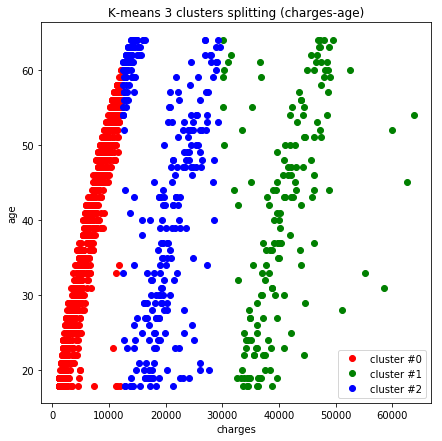

In [75]:
# Visualizing results of 3 cl. KMeans (non-scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X[X['3_cl_KM_label'] == 0]['charges'],\
         X[X['3_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X[X['3_cl_KM_label'] == 1]['charges'],\
         X[X['3_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X[X['3_cl_KM_label'] == 2]['charges'],\
         X[X['3_cl_KM_label'] == 2]['age'],\
         'bo', label='cluster #2')
plt.legend(loc=0)
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 3 clusters splitting (charges-age)')
plt.show()

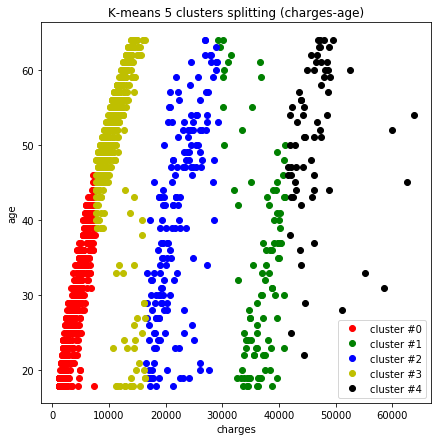

In [76]:
# Visualizing results of 5 cl. KMeans (non-scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X[X['5_cl_KM_label'] == 0]['charges'],\
         X[X['5_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X[X['5_cl_KM_label'] == 1]['charges'],\
         X[X['5_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X[X['5_cl_KM_label'] == 2]['charges'],\
         X[X['5_cl_KM_label'] == 2]['age'],\
         'bo', label='cluster #2')
plt.plot(X[X['5_cl_KM_label'] == 3]['charges'],\
         X[X['5_cl_KM_label'] == 3]['age'],\
         'yo', label='cluster #3')
plt.plot(X[X['5_cl_KM_label'] == 4]['charges'],\
         X[X['5_cl_KM_label'] == 4]['age'],\
         'ko', label='cluster #4')
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 5 clusters splitting (charges-age)')
plt.legend(loc=0)
plt.show()

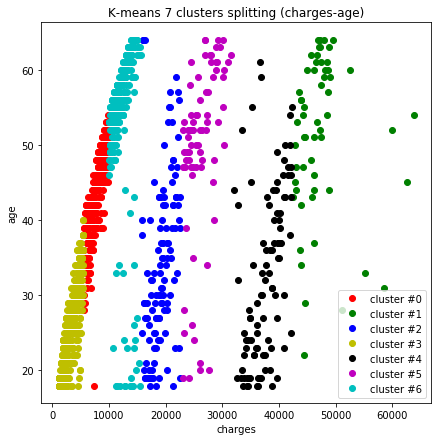

In [77]:
# Visualizing results of 7 cl. KMeans (non-scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X[X['7_cl_KM_label'] == 0]['charges'],\
         X[X['7_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X[X['7_cl_KM_label'] == 1]['charges'],\
         X[X['7_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X[X['7_cl_KM_label'] == 2]['charges'],\
         X[X['7_cl_KM_label'] == 2]['age'],\
         'bo', label='cluster #2')
plt.plot(X[X['7_cl_KM_label'] == 3]['charges'],\
         X[X['7_cl_KM_label'] == 3]['age'],\
         'yo', label='cluster #3')
plt.plot(X[X['7_cl_KM_label'] == 4]['charges'],\
         X[X['7_cl_KM_label'] == 4]['age'],\
         'ko', label='cluster #4')
plt.plot(X[X['7_cl_KM_label'] == 5]['charges'],\
         X[X['7_cl_KM_label'] == 5]['age'],\
         'mo', label='cluster #5')
plt.plot(X[X['7_cl_KM_label'] == 6]['charges'],\
         X[X['7_cl_KM_label'] == 6]['age'],\
         'co', label='cluster #6')
plt.legend(loc=0)
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 7 clusters splitting (charges-age)')
plt.show()

### Point 3
#### Clustering with agglomerative clustering

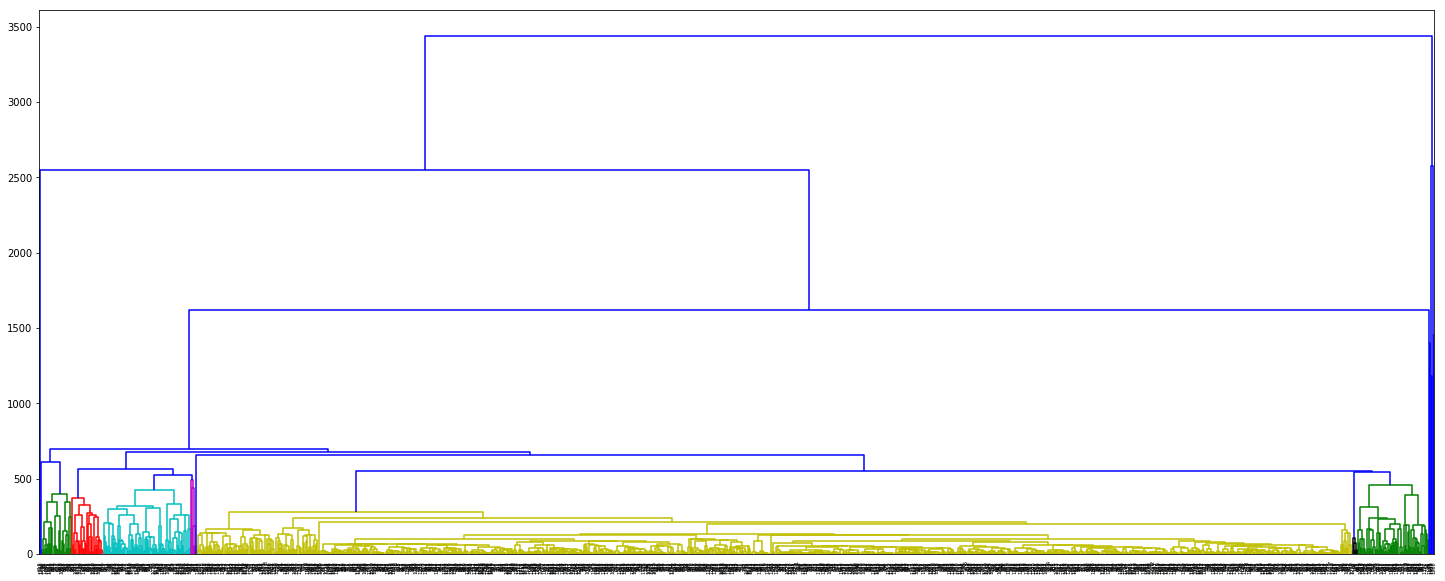

In [78]:
# Applying agglomerative algorithm (linkage) and plotting the dendrogram 
distance_mat = pdist(X) 
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, color_threshold=500)

### Point 4
#### Clusterizing on scalled data

In [79]:
# Preparing data in different way - with scalling of the continouos features
X_sc = get_df_for_models(df, con_cols, bin_cols, cat_cols, 0.9, MinMaxScaler())
X_sc.head()

C:\Users\Alexey\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,bmi,children,charges,sex_male,smoker_yes,northeast,northwest,southeast,southwest
0,0.021739,0.321227,0.0,0.251611,0,1,0,0,0,1
1,0.000000,0.479150,0.2,0.009636,1,0,0,0,1,0
2,0.217391,0.458434,0.6,0.053115,1,0,0,0,1,0
3,0.326087,0.181464,0.0,0.333010,1,0,0,1,0,0
4,0.304348,0.347592,0.0,0.043816,1,0,0,1,0,0


In [80]:
# Choosing the same number of clusters like first time
n_clusters = [3, 5, 7]
KM_sc = []
for i in n_clusters:
    km = KMeans(n_clusters = i, random_state = 18)
    km = km.fit(X_sc)
    KM_sc.append(km)

In [81]:
# Creating new DF with labels in additional columns 
km_label_df = X_sc
km_label_df['3_cl_KM_label'] = KM_sc[0].labels_
km_label_df['5_cl_KM_label'] = KM_sc[1].labels_
km_label_df['7_cl_KM_label'] = KM_sc[2].labels_

In [82]:
km_label_df.head(10)

,age,bmi,children,charges,sex_male,smoker_yes,northeast,northwest,southeast,southwest,3_cl_KM_label,5_cl_KM_label,7_cl_KM_label
0,0.021739,0.321227,0.0,0.251611,0,1,0,0,0,1,2,1,1
1,0.000000,0.479150,0.2,0.009636,1,0,0,0,1,0,0,0,2
2,0.217391,0.458434,0.6,0.053115,1,0,0,0,1,0,0,0,2
3,0.326087,0.181464,0.0,0.333010,1,0,0,1,0,0,1,2,4
4,0.304348,0.347592,0.0,0.043816,1,0,0,1,0,0,1,2,4
5,0.282609,0.263115,0.0,0.042056,0,0,0,0,1,0,0,4,2
6,0.608696,0.470272,0.2,0.113629,0,0,0,0,1,0,0,4,2
7,0.413043,0.316922,0.6,0.098320,0,0,0,1,0,0,1,2,4
8,0.413043,0.373150,0.4,0.084352,1,0,1,0,0,0,1,3,0
9,0.913043,0.265806,0.0,0.443765,0,0,0,1,0,0,1,2,4


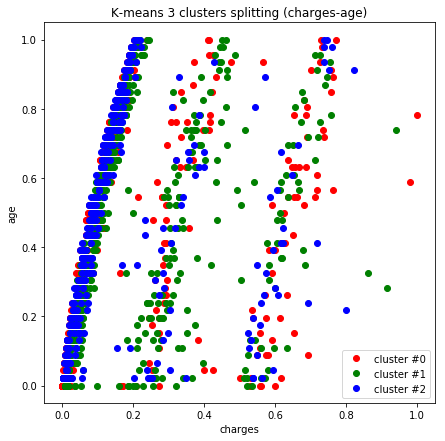

In [83]:
# Visualizing results of 3 cl. KMeans (scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X_sc[X_sc['3_cl_KM_label'] == 0]['charges'],\
         X_sc[X_sc['3_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X_sc[X_sc['3_cl_KM_label'] == 1]['charges'],\
         X_sc[X_sc['3_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X_sc[X_sc['3_cl_KM_label'] == 2]['charges'],\
         X_sc[X_sc['3_cl_KM_label'] == 2]['age'], 'bo', label='cluster #2')
plt.legend(loc=0)
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 3 clusters splitting (charges-age)')
plt.show()

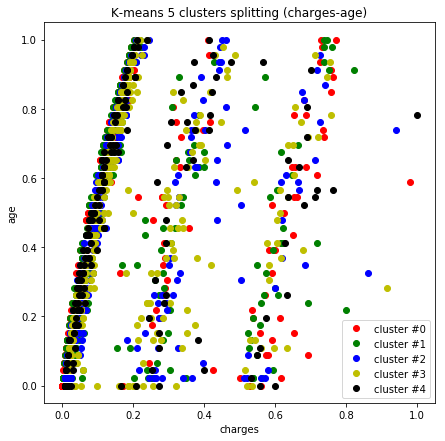

In [84]:
# Visualizing results of 5 cl. KMeans (scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X_sc[X_sc['5_cl_KM_label'] == 0]['charges'],\
         X_sc[X_sc['5_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X_sc[X_sc['5_cl_KM_label'] == 1]['charges'],\
         X_sc[X_sc['5_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X_sc[X_sc['5_cl_KM_label'] == 2]['charges'],\
         X_sc[X_sc['5_cl_KM_label'] == 2]['age'],\
         'bo', label='cluster #2')
plt.plot(X_sc[X_sc['5_cl_KM_label'] == 3]['charges'],\
         X_sc[X_sc['5_cl_KM_label'] == 3]['age'],\
         'yo', label='cluster #3')
plt.plot(X_sc[X_sc['5_cl_KM_label'] == 4]['charges'],\
         X_sc[X_sc['5_cl_KM_label'] == 4]['age'],\
         'ko', label='cluster #4')
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 5 clusters splitting (charges-age)')
plt.legend(loc=0)
plt.show()

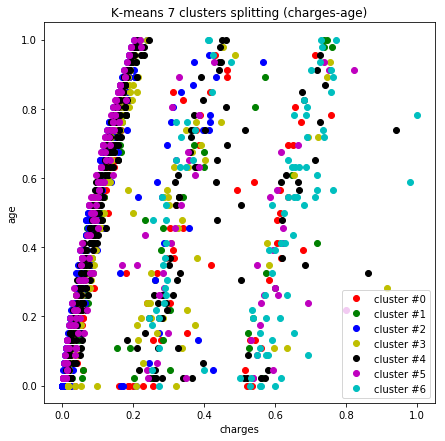

In [85]:
# Visualizing results of 7 cl. KMeans (scalled data)
plt.figure(figsize=(7, 7))
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 0]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 0]['age'],\
         'ro', label='cluster #0')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 1]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 1]['age'],\
         'go', label='cluster #1')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 2]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 2]['age'],\
         'bo', label='cluster #2')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 3]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 3]['age'],\
         'yo', label='cluster #3')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 4]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 4]['age'],\
         'ko', label='cluster #4')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 5]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 5]['age'],\
         'mo', label='cluster #5')
plt.plot(X_sc[X_sc['7_cl_KM_label'] == 6]['charges'],\
         X_sc[X_sc['7_cl_KM_label'] == 6]['age'],\
         'co', label='cluster #6')
plt.legend(loc=0)
plt.xlabel('charges')
plt.ylabel('age')
plt.title('K-means 7 clusters splitting (charges-age)')
plt.show()

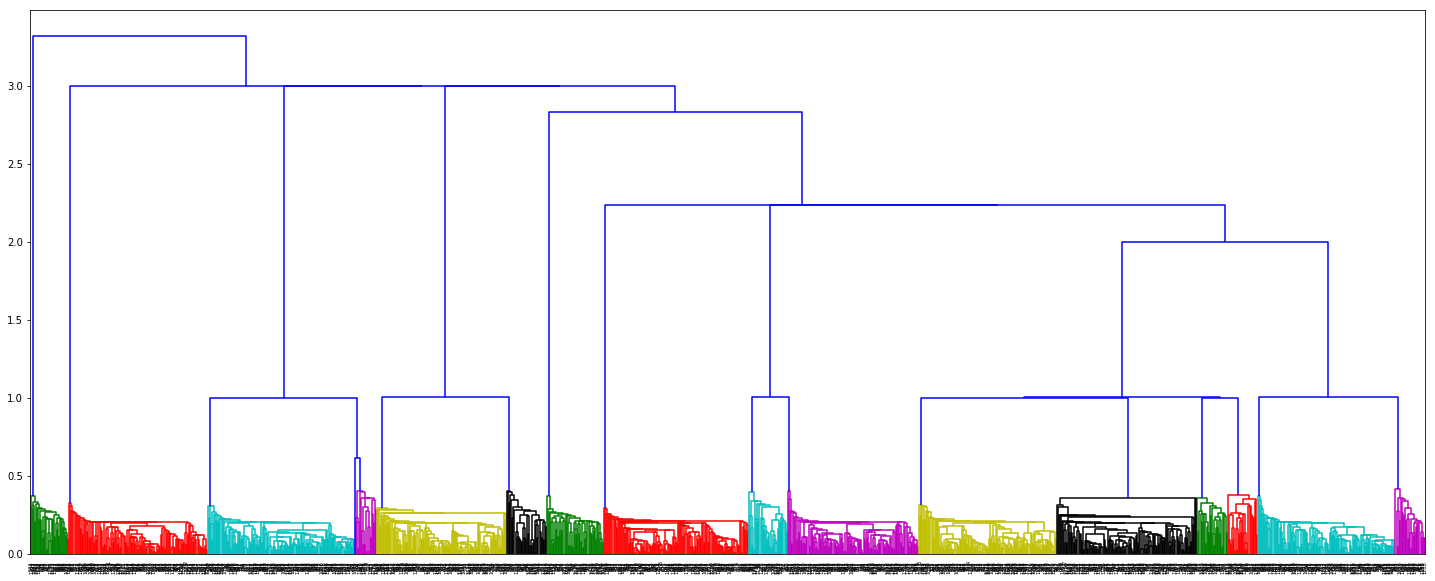

In [86]:
# Applying agglomerative algorithm (linkage) and plotting the dendrogram (now cont features were scalled)
distance_mat = pdist(X_sc) 
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

### Point 5
#### Choosing appropriate number of clustering

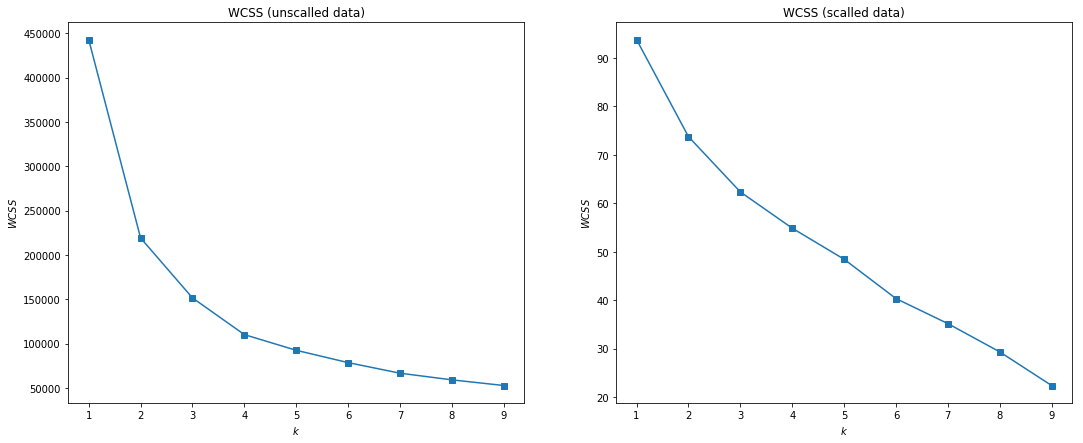

In [87]:
# Plotting the sum of squared distances between the observations and their centroids (WCSS/inertia) vs number of clusters (k)

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=18).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

inertia_sc = []
for m in range(1, 10):
    kmeans_sc = KMeans(n_clusters=m, random_state=18).fit(X_sc)
    inertia_sc.append(np.sqrt(kmeans_sc.inertia_))

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(range(1, 10), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$WCSS$')
plt.title('WCSS (unscalled data)')

plt.subplot(1, 2, 2)
plt.plot(range(1, 10), inertia_sc, marker='s')
plt.xlabel('$k$')
plt.ylabel('$WCSS$')
plt.title('WCSS (scalled data)')

plt.show()

4 clusters is optimal

In [88]:
# Creating custom function to calculate metrics of given clusterizers with different number of clusters
def getClusterizerMetrics(X, clusterizers, n_clusters):
    '''This function will calculate metrics of all given clusterizers for a range of clusters from 2 to n_clusters.
       X - data
       clusterizers - list of choosen clasterizers
       n_clusters - max number of clusters'''
    SLH = []
    CLN = []
    for cl in clusterizers:
                
        for n in list(range(2, n_clusters + 1)):
            CLN.append(cl.__class__.__name__ + '_' + str(n) + '_' + 'clrs')
            cl.set_params(n_clusters = n)
            cl.fit(X)
            SLH.append(metrics.silhouette_score(X, cl.labels_))
    results = pd.DataFrame(data = SLH, columns=['silhouette'], index = CLN)  
    return results

In [89]:
# Choosing clusterizers
KM = KMeans()
AggC = AgglomerativeClustering()
clusterizers = [KM, AggC]

In [90]:
# Getting metrics (silhouette) for choosen clusterizers with max number of clusters 9
getClusterizerMetrics(X, clusterizers, 9)

,silhouette
KMeans_2_clrs,0.733557
KMeans_3_clrs,0.607952
KMeans_4_clrs,0.610506
KMeans_5_clrs,0.598260
KMeans_6_clrs,0.569046
KMeans_7_clrs,0.580479
KMeans_8_clrs,0.583432
KMeans_9_clrs,0.563298
AgglomerativeClustering_2_clrs,0.683242
AgglomerativeClustering_3_clrs,0.647707


### Point 6
#### Creating additional features

One of the new features will be an `'overweight'`. It will be created with a following considerations. If the `bmi` in an observation is higher than the threshold value of `24.99` the `overweight` will value of `yes`, otherwise `no`. 

In [91]:
# Creating new DF from initial one and adding new feature
nf_df = df
nf_df['overweight'] = nf_df['bmi'].apply(lambda x: 'yes' if x > 24.99 else 'no')
bin_cols.append('overweight')

In [92]:
nf_df.head()

,age,sex,bmi,children,smoker,region,charges,overweight
0,19,female,27.900,0,yes,southwest,16884.92400,yes
1,18,male,33.770,1,no,southeast,1725.55230,yes
2,28,male,33.000,3,no,southeast,4449.46200,yes
3,33,male,22.705,0,no,northwest,21984.47061,no
4,32,male,28.880,0,no,northwest,3866.85520,yes


### Point 7
#### Applying PCA

In [93]:
# Preparing data. Now the scaller will be StandardScaller()
X_ss = get_df_for_models(nf_df, con_cols, bin_cols, cat_cols, 0.9, StandardScaler())
X_ss.head()

C:\Users\Alexey\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Alexey\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,age,bmi,children,charges,sex_male,smoker_yes,overweight_yes,northeast,northwest,southeast,southwest
0,-1.438764,-0.453320,-0.908614,0.298584,0,1,1,0,0,0,1
1,-1.509965,0.509621,-0.078767,-0.953689,1,0,1,0,0,1,0
2,-0.797954,0.383307,1.580926,-0.728675,1,0,1,0,0,1,0
3,-0.441948,-1.305531,-0.908614,0.719843,1,0,0,0,1,0,0
4,-0.513149,-0.292556,-0.908614,-0.776802,1,0,1,0,1,0,0


Supposing that 70% of explained variance in data is enough

In [94]:
# Creating custom functon to plot a sum of explained variance proportions vs number of components
def plot_pca_exr(X):
    n_components = list(range(1, X.shape[1] + 1))
    evr = []
    for n in n_components:
        pca = decomposition.PCA(n_components = n)
        pca.fit(X)
        evr.append(sum(pca.explained_variance_ratio_))
    plt.figure(figsize=(10, 7))
    plot = plt.plot(n_components, evr, marker = 's')
    plt.xlabel('$n\:components$')
    plt.ylabel('$Explayned\:variance\:ratio$')
    plt.xticks(np.arange(min(n_components), max(n_components) + 1, 1))
    plt.grid(True)
    return plt.show()

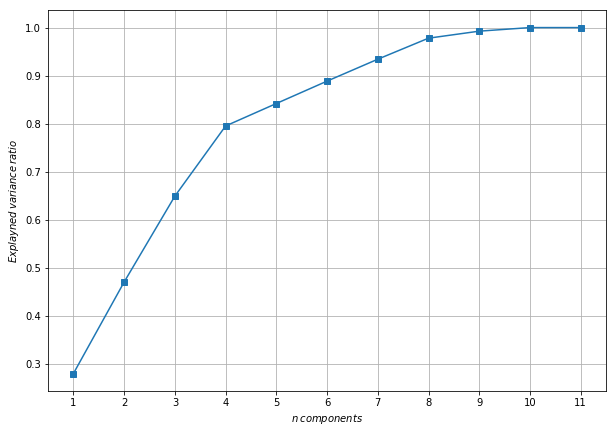

In [95]:
plot_pca_exr(X_ss)

4 components is enough

In [96]:
# Reducing dimensionality of prepared data to 4 components
pca = decomposition.PCA(n_components = 4)
X_ss_pca = pca.fit_transform(X_ss)

### Point 8
#### Clustering PCA'ed data 

In [97]:
# Choosing number of cluster by min of silhouette metric
getClusterizerMetrics(X_ss_pca, clusterizers, 9)

,silhouette
KMeans_2_clrs,0.227926
KMeans_3_clrs,0.252841
KMeans_4_clrs,0.287198
KMeans_5_clrs,0.264820
KMeans_6_clrs,0.252401
KMeans_7_clrs,0.254172
KMeans_8_clrs,0.251779
KMeans_9_clrs,0.255409
AgglomerativeClustering_2_clrs,0.340980
AgglomerativeClustering_3_clrs,0.235572


4 clusters for K-means and 2 clusters for Agglomerative clustering

In [98]:
# Setting choosed parmeters of clusterizers
km = KMeans(n_clusters = 4, random_state = 18)
km.fit(X_ss_pca)

AggC = AgglomerativeClustering(n_clusters = 2)
AggC.fit(X_ss_pca)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [99]:
# Creating new DF with reduced dimensionality
X_ss_pca_df = pd.DataFrame(X_ss_pca, columns = range(1, 5), index = range(0, X_ss_pca.shape[0]))
X_ss_pca_df.head()

,1,2,3,4
0,-0.786328,-0.686581,-0.293717,1.492356
1,-1.119027,-0.810674,1.310990,0.377165
2,-0.413279,0.734664,1.815399,-0.045831
3,-0.676646,0.117947,-1.448302,0.971469
4,-1.082182,-0.727460,-0.260201,-0.089420


In [100]:
# Adding columns with 4 clusters KMeans labels to new DF
X_ss_pca_df['4_cl_KM_label'] = km.labels_
X_ss_pca_df['2_cl_AggC_label'] = AggC.labels_

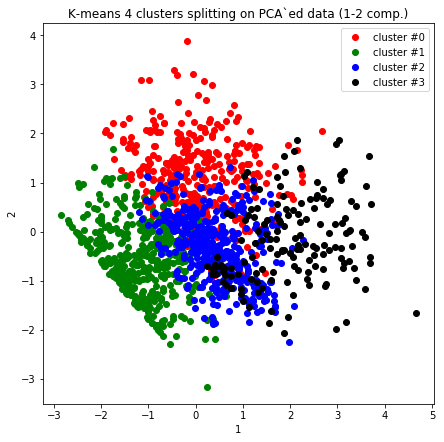

In [101]:
# Visualizing results of 4 cl. KMeans (PCA'ed data)
plt.figure(figsize=(7, 7))
plt.plot(X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 0][1],\
         X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 0][2],\
         'ro', label='cluster #0')
plt.plot(X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 1][1],\
         X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 1][2],\
         'go', label='cluster #1')
plt.plot(X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 2][1],\
         X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 2][2],\
         'bo', label='cluster #2')
plt.plot(X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 3][1],\
         X_ss_pca_df[X_ss_pca_df['4_cl_KM_label'] == 3][2],\
         'ko', label='cluster #3')
plt.legend(loc=0)
plt.xlabel('1')
plt.ylabel('2')
plt.title('K-means 4 clusters splitting on PCA`ed data (1-2 comp.)')
plt.show()

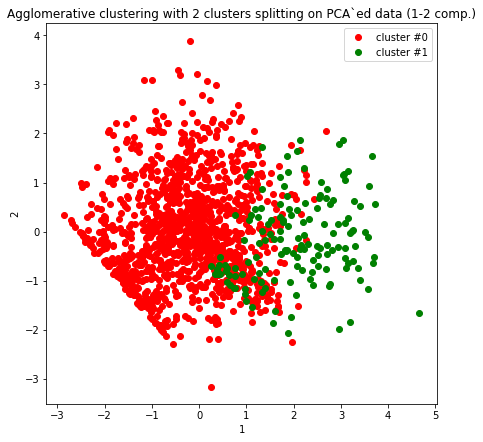

In [102]:
# Visualizing results of 2 cl. Agglomerative clustering (PCA'ed data)
plt.figure(figsize=(7, 7))
plt.plot(X_ss_pca_df[X_ss_pca_df['2_cl_AggC_label'] == 0][1],\
         X_ss_pca_df[X_ss_pca_df['2_cl_AggC_label'] == 0][2],\
         'ro', label='cluster #0')
plt.plot(X_ss_pca_df[X_ss_pca_df['2_cl_AggC_label'] == 1][1],\
         X_ss_pca_df[X_ss_pca_df['2_cl_AggC_label'] == 1][2],\
         'go', label='cluster #1')
plt.legend(loc=0)
plt.xlabel('1')
plt.ylabel('2')
plt.title('Agglomerative clustering with 2 clusters splitting on PCA`ed data (1-2 comp.)')
plt.show()